# Foundation of Probability and Statistics
# ANALISI GIOCO DI CARTE COLLEZIONABILI: MAGIC THE GATHERING

<div align="right"><b>di Emanuele Artioli</b></div>
<div align="center"><b>ABSTRACT</b></div>
Questo progetto analizza componenti estetiche e funzionali del database di carte collezionabili Magic the Gathering dal 1993, anno della sua presentazione.
<div align="center"><b>GIOCO</b></div>
In breve, MtG rappresenta un duello tra maghi, che a turni lanciano magie rappresentate dalle proprie carte. Queste magie richiedono mana, energia elementale di 5 colori attinta da altrettanti tipi di carte terra: Pianura per il bianco, Isola per il blu, Palude per il nero, Montagna per il rosso, e Foresta per il verde. Tra i tipi di magie troviamo creature, incantesimi, stregonerie, artefatti, e non solo. Ogni tipo di magia ha caratteristiche peculiari.
<div align="center"><b>DATI</b></div>
Il dataset è stato scaricato da https://mtgjson.com/ e importato in forma di database SQLite tramite libreria RSQLite. Per la presente analisi, ci concentriamo sulle tabelle:
<ul>
    <li>cards, contenente 70 variabili per più di 50000 carte
    <li>prices, una lista dei prezzi aggiornata quotidianamente
    <li>legalities, la lista dei tornei nei quali ogni carta può essere giocata.
</ul>
Il dataset è relativamente ordinato, ma MtG ha negli anni introdotto molte regole aggiuntive che hanno modificato o sostituito quelle precedenti, rendendo obsolete alcune carte che sono pertanto una complicazione, peraltro difficile da individuare, non secondaria. Si è allora deciso di compiere un'analisi statistica su una parte del dataset 

In [1]:
library(tidyverse)

library(DBI)
con <- dbConnect(RSQLite::SQLite(), dbname="AllPrintings.sqlite")

#--------------------------------------------------------------------

# Multiple plot function
#
# ggplot objects can be passed in ..., or to plotlist (as a list of ggplot objects)
# - cols:   Number of columns in layout
# - layout: A matrix specifying the layout. If present, 'cols' is ignored.
#
# If the layout is something like matrix(c(1,2,3,3), nrow=2, byrow=TRUE),
# then plot 1 will go in the upper left, 2 will go in the upper right, and
# 3 will go all the way across the bottom.
#
multiplot <- function(..., plotlist=NULL, file, cols=1, layout=NULL) {
  library(grid)

  # Make a list from the ... arguments and plotlist
  plots <- c(list(...), plotlist)

  numPlots = length(plots)

  # If layout is NULL, then use 'cols' to determine layout
  if (is.null(layout)) {
    # Make the panel
    # ncol: Number of columns of plots
    # nrow: Number of rows needed, calculated from # of cols
    layout <- matrix(seq(1, cols * ceiling(numPlots/cols)),
                    ncol = cols, nrow = ceiling(numPlots/cols))
  }

 if (numPlots==1) {
    print(plots[[1]])

  } else {
    # Set up the page
    grid.newpage()
    pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))

    # Make each plot, in the correct location
    for (i in 1:numPlots) {
      # Get the i,j matrix positions of the regions that contain this subplot
      matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))

      print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
                                      layout.pos.col = matchidx$col))
    }
  }
}

#--------------------------------------------------------------------------------------------------

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.1.1       v purrr   0.3.2  
v tibble  2.1.1       v dplyr   0.8.0.1
v tidyr   0.8.3       v stringr 1.4.0  
v readr   1.3.1       v forcats 0.4.0  
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


In [2]:
cards <- data.frame(dbReadTable(con, "cards"))
prices <- data.frame(dbReadTable(con, "prices"))
legalities <- data.frame(dbReadTable(con, "legalities"))

prices <- prices[grep("paper", prices$type), c("uuid", "price")] #only paper prices
prices <- prices %>% group_by(uuid) %>% summarize(price = min(price)) #there are cards that have variations, only the cheapest will be included

legacy <- legalities[grep("legacy", legalities$format), "uuid"] #only legacy-legal cards

cards <- cards[cards$isPaper == 1, ]         #only paper,
cards <- cards[cards$isOversized == 0, ]     #usual dimension,
cards <- cards[cards$layout == "normal", ]   #normal layout,
cards <- cards[cards$borderColor == "black", ] #black bordered,
cards <- cards[cards$uuid %in% legacy, ]     #legacy legal cards

#binarizing colors:
cards$white <- 0
cards$white[grep("W", cards$colorIdentity)] <- 1
cards$blue <- 0
cards$blue[grep("U", cards$colorIdentity)] <- 1
cards$black <- 0
cards$black[grep("B", cards$colorIdentity)] <- 1
cards$red <- 0
cards$red[grep("R", cards$colorIdentity)] <- 1
cards$green <- 0
cards$green[grep("G", cards$colorIdentity)] <- 1
colnames(cards)[colnames(cards) == "colorIdentity"] <- "colorless" #colorIdentity becomes the colorless column
cards$colorless[!is.na(cards$colorless)] <- 0 #the rows where colorIdentity had value get colorless = 0
cards$colorless[is.na(cards$colorless)] <- 1 #the remaining (where colorIdentity was NA) get 1

#setting the data types correctly:
suppressWarnings(cards$loyalty <- cards$loyalty %>% as.numeric())
suppressWarnings(cards$power <- cards$power %>% as.numeric())
suppressWarnings(cards$toughness <- cards$toughness %>% as.numeric())
suppressWarnings(cards$colorless <- cards$colorless %>% as.numeric())

# joining the tables in a single dataframe
df <- merge(cards, prices, by="uuid")

# dropping cards columns:
df <- df[, c("name", "convertedManaCost", "white", "blue", "black", "red", "green", "colorless", "supertypes", "types", "subtypes", "rarity", 
             "setCode", "loyalty", "power", "toughness", "price")]

df <- df[sample(nrow(df), 30000), ]

Dopo le modifiche iniziali, il dataset contiene 41033 righe (carte), ognuna con i seguenti attributi:
<table>
  <tr>
    <td><b>Attributo</b></td>
    <td><b>Descrizione</b></td>
    <td><b>Valori</b></td>
  </tr>
  <tr>
    <td><b>artist</b></td>
    <td>Nome completo dell'artista che ha disegnato la carta</td>
    <td>Character</td>
  </tr>
  <tr>
    <td><b>colorIdentity</b></td>
    <td>Uno o più colori attribuiti alla carta</td>
    <td>"W", "U", "B", "R", "G"</td>
  </tr>
  <tr>
    <td><b>manaCost</b></td>
    <td>Quanto di ogni tipo di mana è richiesto per giocare la carta</td>
    <td>Character (un numero, corrispondente al mana non specifico, seguito da una serie di mana specifici</td>
  </tr>
  <tr>
    <td><b>convertedManaCost</b></td>
    <td>l'ammontare totale di mana</td>
    <td>Numeric (range 0 - 16)</td>
  </tr>
  <tr>
    <td><b>flavorText</b></td>
    <td>non game-related, a tale about the role of the card in the Magic ecosystem</td>
    <td>Character</td>
  </tr>
  <tr>
    <td><b>isReserved</b></td>
    <td>whether the card is banned from reprints (usually because it's too powerful and ruins the matches)</td>
    <td>Boolean (1.076% of the cards are Reserved)</td>
  </tr>
  <tr>
    <td><b>name</b></td>
    <td>the card's name</td>
    <td>Character</td>
  </tr>
  <tr>
    <td><b>rarity</b></td>
    <td>The rarity influences the chance of a card being found in a booster pack.</td>
    <td>"Common", "Uncommon", "Rare", or "Mythic"</td>
  </tr>
  <tr>
    <td><b>supertypes</b></td>
    <td>Some cards have a supertype linked to a particular game rule.</td>
    <td>"Legendary", "Snow", "Basic", "World"</td>
  </tr>
  <tr>
    <td><b>types</b></td>
    <td>the main discriminator among cards, defining its nature</td>
    <td>"Creatures", "Artifacts", "Enchantments", "Sorceries", "Instants", "Planeswalkers", "Lands"</td>
  </tr>
  <tr>
    <td><b>subtypes</b></td>
    <td>The most specific characterization of the card. Usual for Creatures and Planeswalkers, optional for artifacts, enchantments, instants, sorceries and lands</td>
    <td>Character</td>
  </tr>
  <tr>
    <td><b>loyalty</b></td>
    <td>(only for the Planeswalker type) value of loyalty the card enters the battlefield with</td>
    <td>Numeric (range 2 - 7)</td>
  </tr>
  <tr>
    <td><b>power</b></td>
    <td>(only for the Creature type) The damage this creature deals to other creatures and players in a fight</td>
    <td>Numeric (range -1 - 16)</td>
  </tr>
  <tr>
    <td><b>toughness</b></td>
    <td>(only for the Creature type) The damage this creature can sustain before dying</td>
    <td>Numeric (range -1 - 16)</td>
  </tr>
  <tr>
    <td><b>setCode</b></td>
    <td>The edition of this instance of the card</td>
    <td>A 3 to 4 character</td>
  </tr>
  <tr>
    <td><b>text</b></td>
    <td>The effects of the card</td>
    <td>Character</td>
  </tr>
  <tr>
    <td><b>uuid</b></td>
    <td>unique identifier of the card</td>
    <td>Character</td>
  </tr>
</table>

Il dataset iniziale conteneva più di 200000 righe, ma queste comprendevano ogni ristampa, nonchè carte ironiche mai pensate per essere giocate e dunque non conformi alle regole del gioco, e altre tipologie di carte utilizzabili solo in contesti speciali. Vi era poi, come è facile prevedere, un gran numero di errori o ambiguità nel dataset. Per tutti questi motivi, uniti alla necessità di utilizzare le tecniche della statistica inferenziale e della teoria della probabilità, si è optato per un campionamento, riducendo a 30000 i data point, e curandosi di mantenere quanto più alta possibile la significatività.

## Panoramica
Ciò che tutte le carte condividono è un costo di mana per essere giocate, questa sarà allora la variabile di partenza sulla quale ogni discrimine verrà evidenziato. Occorre precisare che questo costo viene detratto dal mana totale che un giocatore può attingere ogni turno dalle proprie carte terra, e che egli può giocare al massimo una carta terra in ogni suo turno, sicchè ci si attende dalle carte un impatto sul gioco proporzionale al proprio costo.

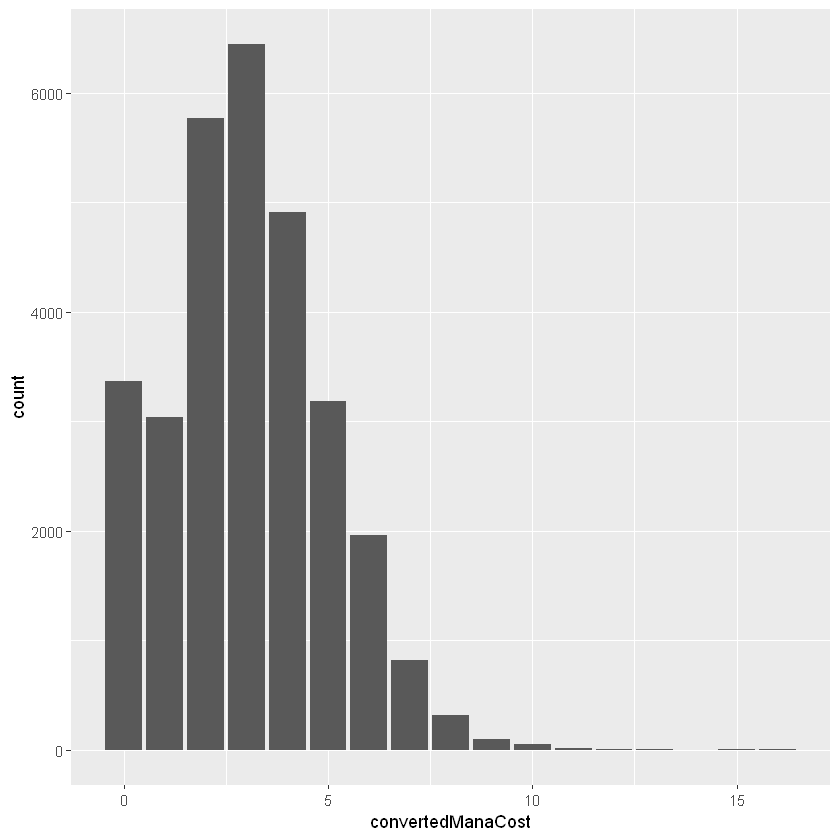

In [21]:
cmc <- ggplot(df, aes(convertedManaCost))
cmc + geom_bar()

In [22]:
summary(df)

     name           convertedManaCost     white             blue       
 Length:30000       Min.   : 0.000    Min.   :0.0000   Min.   :0.0000  
 Class :character   1st Qu.: 2.000    1st Qu.:0.0000   1st Qu.:0.0000  
 Mode  :character   Median : 3.000    Median :0.0000   Median :0.0000  
                    Mean   : 3.047    Mean   :0.2122   Mean   :0.2126  
                    3rd Qu.: 4.000    3rd Qu.:0.0000   3rd Qu.:0.0000  
                    Max.   :16.000    Max.   :1.0000   Max.   :1.0000  
                                                                       
     black             red             green          colorless     
 Min.   :0.0000   Min.   :0.0000   Min.   :0.0000   Min.   :0.0000  
 1st Qu.:0.0000   1st Qu.:0.0000   1st Qu.:0.0000   1st Qu.:0.0000  
 Median :0.0000   Median :0.0000   Median :0.0000   Median :0.0000  
 Mean   :0.2183   Mean   :0.2167   Mean   :0.2208   Mean   :0.0988  
 3rd Qu.:0.0000   3rd Qu.:0.0000   3rd Qu.:0.0000   3rd Qu.:0.0000  
 Max.   :1

In [25]:
sd(df$convertedManaCost, )
sd(df$convertedManaCost, ) / mean(df$convertedManaCost)

[1] 1.948985

[1] 0.6396196

E' subito evidente come la distribuzione sia positivamente asimmetrica, per quanto media e mediana siano quasi coincidenti (mediana = 3, media = 3.047). La variabilità è contenuta, con scarto quadratico medio di 1.95 e coefficiente di variazione 0.64.

L'altra caratteristica numerica comune ad ogni carta è il suo prezzo sul mercato secondario, cioè quello di compravendita tra privati. Vediamo allora come questa si inquadra nell'analisi e in relazione alla variabile appena esplorata:

## Analisi per Colore

## Analisi di Creature